# Capstone: Mapping the Antibody Response

**Note**: This capstone is COMPLEX and is just here as a motivating example of using Python to automate report generation for lage-scale laboratory daat. You are not expected to know enough Python at this stage to perform this analysis.

For the final exercise, we will visualize the affinity of the antibody response to different regions of the HIV envelope protein. The data come from experiments in which animals are given an HIV vaccine, and pre- and post-vaccination samples are tested on an HIV peptide array containing thousands of HIV envelope sequences. Each array has triplicates of each sequence. 

We need to do the following for each animal:

- read in pre-vaccination peptide array data a text file
- read in post-vaccination peptide array data a text file
- find the change in fluorescence reading from pre- to post-vaccination sample
- find the median value across the 3 replicates per sequence 
- extract the clade data for each peptide
- read in a metadata file showing the mapping of peptide sequence to a region on the HIV envelope
- find the region each sequence is mapped to

Then, the investigator has asked us to plot the following heatmap where each cell contains the sum of values for sequences belonging to that clade, normalized by the number of such sequences in each clade.

![heatmap](figs/heatmap.png)

These notes walk you through the steps taken to generate such heatmaps automatically, starting from the raw text data and metadata files. The skill level required goes beyond what was covered in this two-day workshop, although much of it should seem familiar. Hopefully, this will provide a real-world example how continuing to learn to code will pay off in the long run.

The data comes from the paper [Schiffner et al., J Virol. 2013 Sep;87(18):10163-72](http://www.ncbi.nlm.nih.gov/pubmed/23843636).

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Preview

Here is some code that can generate the above figure from raw data, but it is likely to be incomprehensible. Later we will unpack the code into the individual steps.

```python

def baseline(x):
    return max(200, x.median() + 3*x.std(ddof=1))

def process_meta(path, clade_cols):
    """Collect steps to transform metadata here."""

    meta = pd.read_table(meta_path, na_values='-')
    clades = sorted(set(meta[clade_cols].values.ravel()) - set([np.nan]))
    for clade in clades:
        meta[clade] = (meta[clade_cols] == clade).any(axis=1)
    meta = meta[['PeptideSeq', 'Region'] + clades]
    meta = pd.melt(meta, ['PeptideSeq', 'Region'])
    meta = meta[meta.value == True].drop('value', axis=1)
    meta.columns = ['seq', 'region', 'clade']
    return meta

def process_baseline(path):
    """Steps to calculate baseline values."""

    pre = pd.read_table(path, skiprows=34)
    pre = pre[['ID', 'Block', 'F635 Median - B635']]
    pre.columns = ['seq', 'block', 'pre']
    d = pre.groupby('seq').agg({'pre': baseline})
    d = d.reset_index()
    return d

def process_vaccinated(path):
    """Steps to calculate vaccinated median values."""

    post = pd.read_table(path, skiprows=34)
    post = post[['ID', 'Block', 'F635 Median - B635']]
    post.columns = ['seq', 'block', 'post']
    d = post.groupby('seq').agg({'post': np.median})
    d = d.reset_index()
    return d

def process_pair(pre_path, post_path):
    """Process a pair of pre- and post-files."""

    s1 = os.path.split(pre_path)[-1][:3]
    s2 = os.path.split(pre_path)[-1][:3]
    assert(s1 == s2)

    pre = process_baseline(pre_path)
    post = process_vaccinated(post_path)
    df = pd.merge(pre, post, on=['seq'])
    df['signal'] = df['post'] - df['pre']
    df['signal'] = df['signal'].clip_lower(1)
    df['subject'] = s1
    df = df.drop(['pre', 'post'], axis=1)
    return df

def process_all(meta_path, pairs, clade_cols):
    """Process metadata and all pairs of files into a single data frame."""

    meta = meta = process_meta(meta_path, clade_cols)

    dfs = []
    for pre_path, post_path in pairs:
        df = process_pair(pre_path, post_path)
        dfs.append(df)
    dfs = pd.concat(dfs)
    data = pd.merge(dfs, meta)
    return data


base_dir = os.path.join('data', 'capstone2')
meta_path = os.path.join(base_dir, 'Copy_Peptides Lib_HIV_Revised BK_20160905.txt')
pre_files = sorted(glob.glob(os.path.join(base_dir, '*pre_*anon.txt')))
post_files = sorted(glob.glob(os.path.join(base_dir, '*wk24_*anon.txt')))
pairs = list(zip(pre_files, post_files))

data = process_all(meta_path, pairs, clade_cols)
data.head()

wt = ['770', '771', '776']
gla = ['778', '780', '783']

data.ix[data.subject.isin(wt), 'group'] = 'wt'
data.ix[data.subject.isin(gla), 'group'] = 'gla'

nrows = len(clades)
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3*nrows))

low, high, step = 1, 162, 5
for i, (clade, df_clade) in enumerate(data[data.protein == 'gp120'].groupby('clade')):
    for j, (group, df_group) in enumerate(df_clade.groupby('group')):
        ax = axes[i, j]
        hm = df_group.groupby(['region', 'subject'])[['signal']].mean()
        hm = hm.unstack().T.reset_index(level=0, drop=True)
        hm.columns = hm.columns.astype('int')
        sns.heatmap(hm, ax=ax, linewidth=0.01, cbar=j)
        ax.set_title(clade)
        ax.set_xlim(low, high)
        ax.set_xticks(range(low, high+1, step))
        ax.set_xticklabels(range(low, high+1, step))
        ax.set_ylabel('Animal')
plt.tight_layout()
```

### Paths to data and metadata files

We use `os.path.join` to create paths to files that will work regardless of the operating system. In particular, Windows uses the forward slash while Unix and Macs use the backwards slash to separate parts of the path.

In [2]:
base_dir = os.path.join('data', 'capstone2')
meta_path = os.path.join(base_dir, 'Copy_Peptides Lib_HIV_Revised BK_20160905.txt')
pre_files = sorted(glob.glob(os.path.join(base_dir, '*pre_*anon.txt')))
post_files = sorted(glob.glob(os.path.join(base_dir, '*wk24_*anon.txt')))
pairs = list(zip(pre_files, post_files))

## Step-by-step

### What are the paths to files that were created?

In [3]:
base_dir

'data/capstone2'

In [4]:
meta_path

'data/capstone2/Copy_Peptides Lib_HIV_Revised BK_20160905.txt'

In [5]:
pairs

[('data/capstone2/770 pre_20130118_S1_460_anon.txt',
  'data/capstone2/770 wk24_20130118_S2_460_anon.txt'),
 ('data/capstone2/771 pre_20130118_S3_460_anon.txt',
  'data/capstone2/771 wk24_20130118_S4_460_anon.txt'),
 ('data/capstone2/776 pre_20130118_S5_460_anon.txt',
  'data/capstone2/776 wk24_20130118_S6_460_anon.txt'),
 ('data/capstone2/778 pre_20130118_S7_460_anon.txt',
  'data/capstone2/778 wk24_20130118_S8_460_anon.txt'),
 ('data/capstone2/780 pre_20130118_S9_460_anon.txt',
  'data/capstone2/780 wk24_20130118_S10_460_anon.txt')]

### Load the metadata file into a `pandas` data frame

Looking at the original text file, we see that `-` indicates blank space and can be coded as missing. Also we note that there are blank rows in the text file that we must take care of. We take a peek at the text file using a standrad Python idioms.

In [6]:
with open('data/capstone2/Copy_Peptides Lib_HIV_Revised BK_20160905.txt') as f:
    for i, line in enumerate(f):
        print(line, end='')
        if i > 15:
            break

OriNum	NewNum	PeptideSeq	Region	Seqs	N.ident	Batch	12	11	10	9	8	1	2	3	4	5	6	7		
1	E1	MRVMGIQRNWQHLWR	1	1	1	Ori	-	-	-	-	-	-	M Con	-	-	-	-	-	-	
2	E2	MRVMGIQRNCQHLWR	1	2	1	Ori	-	-	-	-	-	-	-	A Con	-	-	-	-	-	
3	E3	MRVKGIRKNYQHLWR	1	3	1	Ori	-	-	-	-	-	-	-	-	B Con	-	-	-	-	
4	E4	MRVRGILRNWQQWWI	1	4	1	Ori	-	-	-	-	-	-	-	-	-	C Con	-	-	-	
5	E5	MRVRGIERNYQHLWR	1	5	1	Ori	-	-	-	-	-	-	-	-	-	-	D Con	-	-	AE.A244
6	E6	MRVKETQMNWPNLWK	1	6	1	Ori	-	-	-	-	-	-	-	-	-	-	-	AE Con	-	
7	E7	MRVMGIQKNYPLLWR	1	7	1	Ori	-	-	-	-	-	-	-	-	-	-	-	-	AG Con	
-	E1426	MRVRGIWKNWPQWLI	1	11	1	New	-	-	C.1086	-	-	-	-	-	-	-	-	-	-	
-	E1427	MRVMGTQKNCQQWWI	1	12	1	New	-	C.TV1	-	-	-	-	-	-	-	-	-	-	-	
-	E1920	MRVREILRNWQRWWT	1	13	1	New	C.ZM651	-	-	-	-	-	-	-	-	-	-	-	-	
																				
8	E8	MGIQRNWQHLWRWGT	2	1	1	Ori	-	-	-	-	-	-	M Con	-	-	-	-	-	-	
9	E9	MGIQRNCQHLWRWGT	2	2	1	Ori	-	-	-	-	-	-	-	A Con	-	-	-	-	-	
10	E10	KGIRKNYQHLWRWGT	2	3	1	Ori	-	-	-	-	-	-	-	-	B Con	-	-	-	-	
11	E11	RGILRNWQQWWIWGI	2	4	1	Ori	-	-	-	-	-	-	-	-	-	C Con	-	-	-	
12	

#### Use `pandas` to read in table

In [7]:
meta = pd.read_table(meta_path, na_values='-')

#### We have some blank rows

In [8]:
meta.ix[:11, :8]

,OriNum,NewNum,PeptideSeq,Region,Seqs,N.ident,Batch,12
0,1.0,E1,MRVMGIQRNWQHLWR,1.0,1,1.0,Ori,NaN
1,2.0,E2,MRVMGIQRNCQHLWR,1.0,2,1.0,Ori,NaN
2,3.0,E3,MRVKGIRKNYQHLWR,1.0,3,1.0,Ori,NaN
3,4.0,E4,MRVRGILRNWQQWWI,1.0,4,1.0,Ori,NaN
4,5.0,E5,MRVRGIERNYQHLWR,1.0,5,1.0,Ori,NaN
5,6.0,E6,MRVKETQMNWPNLWK,1.0,6,1.0,Ori,NaN
6,7.0,E7,MRVMGIQKNYPLLWR,1.0,7,1.0,Ori,NaN
7,NaN,E1426,MRVRGIWKNWPQWLI,1.0,11,1.0,New,NaN
8,NaN,E1427,MRVMGTQKNCQQWWI,1.0,12,1.0,New,NaN
9,NaN,E1920,MRVREILRNWQRWWT,1.0,13,1.0,New,C.ZM651


#### Now get rid of blank rows

In [9]:
meta = meta.dropna(axis=0, how='all')

#### Check that blank rows have been removed

In [10]:
meta.ix[:11, :8]

,OriNum,NewNum,PeptideSeq,Region,Seqs,N.ident,Batch,12
0,1.0,E1,MRVMGIQRNWQHLWR,1.0,1,1.0,Ori,NaN
1,2.0,E2,MRVMGIQRNCQHLWR,1.0,2,1.0,Ori,NaN
2,3.0,E3,MRVKGIRKNYQHLWR,1.0,3,1.0,Ori,NaN
3,4.0,E4,MRVRGILRNWQQWWI,1.0,4,1.0,Ori,NaN
4,5.0,E5,MRVRGIERNYQHLWR,1.0,5,1.0,Ori,NaN
5,6.0,E6,MRVKETQMNWPNLWK,1.0,6,1.0,Ori,NaN
6,7.0,E7,MRVMGIQKNYPLLWR,1.0,7,1.0,Ori,NaN
7,NaN,E1426,MRVRGIWKNWPQWLI,1.0,11,1.0,New,NaN
8,NaN,E1427,MRVMGTQKNCQQWWI,1.0,12,1.0,New,NaN
9,NaN,E1920,MRVREILRNWQRWWT,1.0,13,1.0,New,C.ZM651


### Extract clades from `meta`

Each peptide sequence may match one or more HIV clades. The clade information is in the columns `'12', '11', '10', '9', '8', '1', '2', '3', '4', '5', '6', '7', 'Unnamed: 19', 'Unnamed: 20'`, and we will need to extract them from there.

In [11]:
clade_cols = ['12', '11', '10', '9', '8', '1', '2', '3', '4', '5', '6', '7', 'Unnamed: 19', 'Unnamed: 20']
meta[clade_cols].head()

,12,11,10,9,8,1,2,3,4,5,6,7,Unnamed: 19,Unnamed: 20
0,NaN,NaN,NaN,NaN,NaN,NaN,M Con,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A Con,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B Con,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C Con,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D Con,NaN,NaN,AE.A244


#### First find all unique clades in the values within `clade_cols`

In [12]:
clades = sorted(set(meta[clade_cols].values.ravel()) - set([np.nan]))

In [13]:
clades

['A Con',
 'AE Con',
 'AE.A244',
 'AE.TH023',
 'AG Con',
 'B Con',
 'B.MN',
 'C Con',
 'C.1086',
 'C.TV1',
 'C.ZM651',
 'D Con',
 'M Con']

#### Create a new column for each clade where the value is True if the clade is present in that row and false otherwise

In [14]:
for clade in clades:
    meta[clade] = (meta[clade_cols] == clade).any(axis=1)

#### Drop all columns except `Region`, `PeptideSeq` and the columns for clades

In [15]:
meta = meta[['PeptideSeq', 'Region'] + clades]
meta.head()

,PeptideSeq,Region,A Con,AE Con,AE.A244,AE.TH023,AG Con,B Con,B.MN,C Con,C.1086,C.TV1,C.ZM651,D Con,M Con
0,MRVMGIQRNWQHLWR,1.0,False,False,False,False,False,False,False,False,False,False,False,False,True
1,MRVMGIQRNCQHLWR,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False
2,MRVKGIRKNYQHLWR,1.0,False,False,False,False,False,True,False,False,False,False,False,False,False
3,MRVRGILRNWQQWWI,1.0,False,False,False,False,False,False,False,True,False,False,False,False,False
4,MRVRGIERNYQHLWR,1.0,False,False,True,False,False,False,False,False,False,False,False,True,False


#### Reshape `meta` so that it only contains 4 columns `PeptideSeq`, `Region` , `variable` and `value` 

Then drop all rows where the value of `variable` is `False`.

In [16]:
meta = pd.melt(meta, ['PeptideSeq', 'Region'])
meta.head()

,PeptideSeq,Region,variable,value
0,MRVMGIQRNWQHLWR,1.0,A Con,False
1,MRVMGIQRNCQHLWR,1.0,A Con,True
2,MRVKGIRKNYQHLWR,1.0,A Con,False
3,MRVRGILRNWQQWWI,1.0,A Con,False
4,MRVRGIERNYQHLWR,1.0,A Con,False


In [17]:
meta = meta[meta.value == True].drop('value', axis=1)
meta.head()

,PeptideSeq,Region,variable
1,MRVMGIQRNCQHLWR,1.0,A Con
11,MGIQRNCQHLWRWGT,2.0,A Con
21,QRNCQHLWRWGTMIL,3.0,A Con
31,CQHLWRWGTMILGMI,4.0,A Con
40,LWRWGTMILGMIIIC,5.0,A Con


#### Reanme the columns of meta as `seq`, `region`, `clade`

In [18]:
meta.columns = ['seq', 'region', 'clade']

### Load a data file into a dataframe

We'll just use one of the pre files as an example.

In [19]:
path = pairs[0][0]
path

'data/capstone2/770 pre_20130118_S1_460_anon.txt'

**Note**: The `! head` command may not work in Windows. In that case, you can use regular Python functions to print the first 15 lines as shown in the section `Load the metadata file into a pandas data frame`.

In [20]:
! head -n 15 "$path"

ATF	1.0
32	58    
"Type=GenePix Export 3"
"DateTime=2013/01/18 16:53:39"
"Settings="
"GalFile="
"PixelSize=10"
"Wavelengths=635	532"
"ImageFiles="
"NormalizationMethod=None"
"NormalizationFactors=1	1"
"JpegImage="
"StdDev=Type 1"
"RatioFormulations=W1/W2 (635/532)"
"FeatureType=Circular"


#### Hmm, the top part of the file does not actually contain the data we are looking for

It turns out that the first 34 lines are information about the assay we don't need for this exercise. We use some Unix shell commands to show the lines 31-40.

In [21]:
! head -n 40 "$path" | tail -n 10

"ScanArea=1"
"Supplier=Arrayjet Ltd"
"ArrayerSoftwareName=Aj Marathon"
"ArrayerSoftwareVersion=1.3.4"
"Flags"	"Normalize"	"Autoflag"	"Block"	"Column"	"Row"	"Name"	"ID"	"X"	"Y"	"Dia."	"F635 Median"	"F635 Mean"	"F635 SD"	"F635 CV"	"B635"	"B635 Median"	"B635 Mean"	"B635 SD"	"B635 CV"	"% > B635+1SD"	"% > B635+2SD"	"F635 % Sat."	"F532 Median"	"F532 Mean"	"F532 SD"	"F532 CV"	"B532"	"B532 Median"	"B532 Mean"	"B532 SD"	"B532 CV"	"% > B532+1SD"	"% > B532+2SD"	"F532 % Sat."	"F635 Total Intensity"	"F532 Total Intensity"	"SNR 635"	"SNR 532"	"Ratio of Medians (635/532)"	"Ratio of Means (635/532)"	"Median of Ratios (635/532)"	"Mean of Ratios (635/532)"	"Ratios SD (635/532)"	"Rgn Ratio (635/532)"	"Rgn R2 (635/532)"	"Log Ratio (635/532)"	"F635 Median - B635"	"F532 Median - B532"	"F635 Mean - B635"	"F532 Mean - B532"	"Sum of Medians (635/532)"	"Sum of Means (635/532)"	"F Pixels"	"B Pixels"	"Circularity"	"Index"	"Annotation"
0	0	0	1	1	1	"E73-73"	"WVTVYYGVPVWKDAE"	2050	5160	100	347	359	160	44	267	267	276

#### Use `pandas` to read in the file, dropping the first 34 rows

In [22]:
pre = pd.read_table(path, skiprows=34)

In [23]:
pre.ix[:10, :8]

,Flags,Normalize,Autoflag,Block,Column,Row,Name,ID
0,0,0,0,1,1,1,E73-73,WVTVYYGVPVWKDAE
1,0,0,0,1,2,1,E8-8,MGIQRNWQHLWRWGT
2,-50,0,0,1,3,1,E1932,FCASDAKSYEKEVHN
3,0,0,0,1,4,1,E1435,WLIWSILGFWIGNME
4,0,0,0,1,5,1,E1449,EDLWVTVYYGVPVWR
5,0,0,0,1,6,1,E1427,MRVMGTQKNCQQWWI
6,-50,0,0,1,7,1,E1467,FCASDAKAQETEAHN
7,-50,0,0,1,8,1,E42-42,MILGMIIICSAAENL
8,0,0,0,1,9,1,E75-75,WVTVYYGVPVWRDAD
9,0,0,0,1,10,1,E7-7,MRVMGIQKNYPLLWR


#### Drop unused columns

For this analysis, we are only interested in the columns named "`ID`", "`Block`" and "`F635 Median - B635`", and we can drop the rest of the many columns for simplicity. We never, ever touch the raw data files, so we can always get the other columns by re-reading them in if necessary.

In [24]:
pre = pre[['ID', 'Block', 'F635 Median - B635']]

In [25]:
pre.head()

,ID,Block,F635 Median - B635
0,WVTVYYGVPVWKDAE,1,80
1,MGIQRNWQHLWRWGT,1,310
2,FCASDAKSYEKEVHN,1,-185
3,WLIWSILGFWIGNME,1,158
4,EDLWVTVYYGVPVWR,1,568


#### Do the same thing for the file in `pairs[0][1]` and create a `post` data frame. All the data files have the exact same format, so you must drop the first 34 rows as before.

In [26]:
path = pairs[0][1]
post = pd.read_table(path, skiprows=34)
post = post[['ID', 'Block', 'F635 Median - B635']]

In [27]:
post.head()

,ID,Block,F635 Median - B635
0,WVTVYYGVPVWKDAE,1,0
1,MGIQRNWQHLWRWGT,1,82
2,FCASDAKSYEKEVHN,1,-13
3,WLIWSILGFWIGNME,1,119
4,EDLWVTVYYGVPVWR,1,954


### Find the change in intensity before and after vaccination 

#### First change the column names for convenience

- For `pre`, call the columns `seq`, `block`, `pre`
- For `post` call the columns `seq`, `block`, `post`

In [28]:
pre.columns = ['seq', 'block', 'pre']
post.columns = ['seq', 'block', 'post']

#### Calculate summary statistics

- from `pre`, create a new data frame `baseline` that contains seq and a column equal to the median value across blocks + 3 SD - if the resulting value is less than 200, use 200 instead
- for `post` create a new data frame `vaccine` for the median value across blocks

In [29]:
def baseline(x):
    return max(200, x.median() + 3*x.std(ddof=1))

In [30]:
base = pre.groupby('seq').agg({'pre': baseline})
base = base.reset_index()
base.head()

,seq,pre
0,AA,200.000000
1,AAARLGAVILFVVIV,200.000000
2,AARAVELLGRSSLRG,335.874922
3,AARIVELLGRRGWEA,537.473794
4,AARTVELLGHSSLKG,200.000000


In [31]:
vaccine = post.groupby('seq').agg({'post': np.median})
vaccine = vaccine.reset_index()
vaccine.head()

,seq,post
0,AA,-94
1,AAARLGAVILFVVIV,-54
2,AARAVELLGRSSLRG,492
3,AARIVELLGRRGWEA,636
4,AARTVELLGHSSLKG,357


#### Create a datta frame `df` by merging baseline and vaccine on `seq` 

In [32]:
df = pd.merge(base, vaccine, on=['seq'])
df.head()

,seq,pre,post
0,AA,200.000000,-94
1,AAARLGAVILFVVIV,200.000000,-54
2,AARAVELLGRSSLRG,335.874922,492
3,AARIVELLGRRGWEA,537.473794,636
4,AARTVELLGHSSLKG,200.000000,357


#### Create a new column `signal` in `df` by subtracting the `pre` column from the `post` column

If the resulting value is less than 1, use 1 instead.

In [33]:
df['signal'] = df['post'] - df['pre']
df['signal'] = df['signal'].clip_lower(1)
df.head()

,seq,pre,post,signal
0,AA,200.000000,-94,1.000000
1,AAARLGAVILFVVIV,200.000000,-54,1.000000
2,AARAVELLGRSSLRG,335.874922,492,156.125078
3,AARIVELLGRRGWEA,537.473794,636,98.526206
4,AARTVELLGHSSLKG,200.000000,357,157.000000


#### Drop the `pre` and `post` columns since we don't need them anymore

In [34]:
df = df.drop(['pre', 'post'], axis=1)
df.head()

,seq,signal
0,AA,1.000000
1,AAARLGAVILFVVIV,1.000000
2,AARAVELLGRSSLRG,156.125078
3,AARIVELLGRRGWEA,98.526206
4,AARTVELLGHSSLKG,157.000000


### Merge with metadta

#### Merge `df` and `meta` on `seq`  to create a new data frame called `data`

In [35]:
data = pd.merge(df, meta, on='seq')

In [36]:
data.head()

,seq,signal,region,clade
0,AARAVELLGRSSLRG,156.125078,254.0,C Con
1,AARIVELLGRRGWEA,98.526206,254.0,D Con
2,AARTVELLGHSSLKG,157.000000,254.0,A Con
3,AARTVELLGHSSLKG,157.000000,254.0,AE Con
4,AARTVELLGHSSLKG,157.000000,254.0,AG Con


### Now do this for all files in a loop

#### Refactor code into functions to make the code more manageable

In [37]:
def process_meta(path, clade_cols):
    """Collect steps to transform metadata here."""

    meta = pd.read_table(meta_path, na_values='-')
    clades = sorted(set(meta[clade_cols].values.ravel()) - set([np.nan]))
    for clade in clades:
        meta[clade] = (meta[clade_cols] == clade).any(axis=1)
    meta = meta[['PeptideSeq', 'Region'] + clades]
    meta = pd.melt(meta, ['PeptideSeq', 'Region'])
    meta = meta[meta.value == True].drop('value', axis=1)
    meta.columns = ['seq', 'region', 'clade']
    return meta

def process_baseline(path):
    """Steps to calculate baseline values."""

    pre = pd.read_table(path, skiprows=34)
    pre = pre[['ID', 'Block', 'F635 Median - B635']]
    pre.columns = ['seq', 'block', 'pre']
    d = pre.groupby('seq').agg({'pre': baseline})
    d = d.reset_index()
    return d

def process_vaccinated(path):
    """Steps to calculate vaccinated median values."""

    post = pd.read_table(path, skiprows=34)
    post = post[['ID', 'Block', 'F635 Median - B635']]
    post.columns = ['seq', 'block', 'post']
    d = post.groupby('seq').agg({'post': np.median})
    d = d.reset_index()
    return d

def process_pair(pre_path, post_path):
    """Process a pair of pre- and post-files."""

    s1 = os.path.split(pre_path)[-1][:3]
    s2 = os.path.split(pre_path)[-1][:3]
    assert(s1 == s2)

    pre = process_baseline(pre_path)
    post = process_vaccinated(post_path)
    df = pd.merge(pre, post, on=['seq'])
    df['signal'] = df['post'] - df['pre']
    df['signal'] = df['signal'].clip_lower(1)
    df['subject'] = s1
    df = df.drop(['pre', 'post'], axis=1)
    return df

In [38]:
def process_all(meta_path, pairs, clade_cols):
    """Process metadata and all pairs of files into a single data frame."""

    meta = meta = process_meta(meta_path, clade_cols)

    dfs = []
    for pre_path, post_path in pairs:
        df = process_pair(pre_path, post_path)
        dfs.append(df)
    dfs = pd.concat(dfs)
    data = pd.merge(dfs, meta)
    return data

In [39]:
clade_cols = ['12', '11', '10', '9', '8', '1', '2', '3', '4', '5', '6', '7', 'Unnamed: 19', 'Unnamed: 20']
base_dir = os.path.join('data', 'capstone2')
meta_path = os.path.join(base_dir, 'Copy_Peptides Lib_HIV_Revised BK_20160905.txt')
pre_files = sorted(glob.glob(os.path.join(base_dir, '*pre_*anon.txt')))
post_files = sorted(glob.glob(os.path.join(base_dir, '*wk24_*anon.txt')))
pairs = list(zip(pre_files, post_files))

In [40]:
data = process_all(meta_path, pairs, clade_cols)
data.head()

,seq,signal,subject,region,clade
0,AARAVELLGRSSLRG,156.125078,770,254.0,C Con
1,AARAVELLGRSSLRG,1.000000,771,254.0,C Con
2,AARAVELLGRSSLRG,1.000000,776,254.0,C Con
3,AARAVELLGRSSLRG,1.000000,778,254.0,C Con
4,AARAVELLGRSSLRG,1.000000,780,254.0,C Con


### Assigned groups

Group information GLA-Rb Study:

- WT Group: 770, 771, 776
- GLA Group: 778, 780, 783

In [41]:
wt = ['770', '771', '776']
gla = ['778', '780', '783']

In [42]:
data.ix[data.subject.isin(wt), 'group'] = 'wt'
data.ix[data.subject.isin(gla), 'group'] = 'gla'
data.head()

,seq,signal,subject,region,clade,group
0,AARAVELLGRSSLRG,156.125078,770,254.0,C Con,wt
1,AARAVELLGRSSLRG,1.000000,771,254.0,C Con,wt
2,AARAVELLGRSSLRG,1.000000,776,254.0,C Con,wt
3,AARAVELLGRSSLRG,1.000000,778,254.0,C Con,gla
4,AARAVELLGRSSLRG,1.000000,780,254.0,C Con,gla


### Assigned envelope proteins

If region <= 163, then protein = gp120, otherwise protein = gp144

## Graphics

In [43]:
data.ix[data.region <= 163, 'protein'] = 'gp120'
data.ix[data.region >163, 'protein'] = 'gp144'

In [44]:
data.head()

,seq,signal,subject,region,clade,group,protein
0,AARAVELLGRSSLRG,156.125078,770,254.0,C Con,wt,gp144
1,AARAVELLGRSSLRG,1.000000,771,254.0,C Con,wt,gp144
2,AARAVELLGRSSLRG,1.000000,776,254.0,C Con,wt,gp144
3,AARAVELLGRSSLRG,1.000000,778,254.0,C Con,gla,gp144
4,AARAVELLGRSSLRG,1.000000,780,254.0,C Con,gla,gp144


### Plotting signal against region

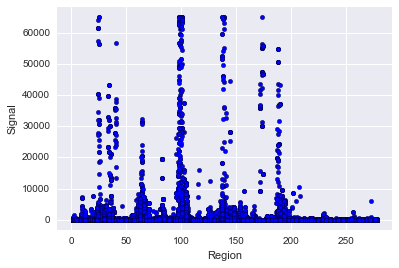

In [45]:
plt.scatter(data.region, data.signal)
plt.margins(0.05)
plt.xlabel('Region')
plt.ylabel('Signal')
pass

### Conditioning plots on categorical variables

Warning: This takes a while to complete.

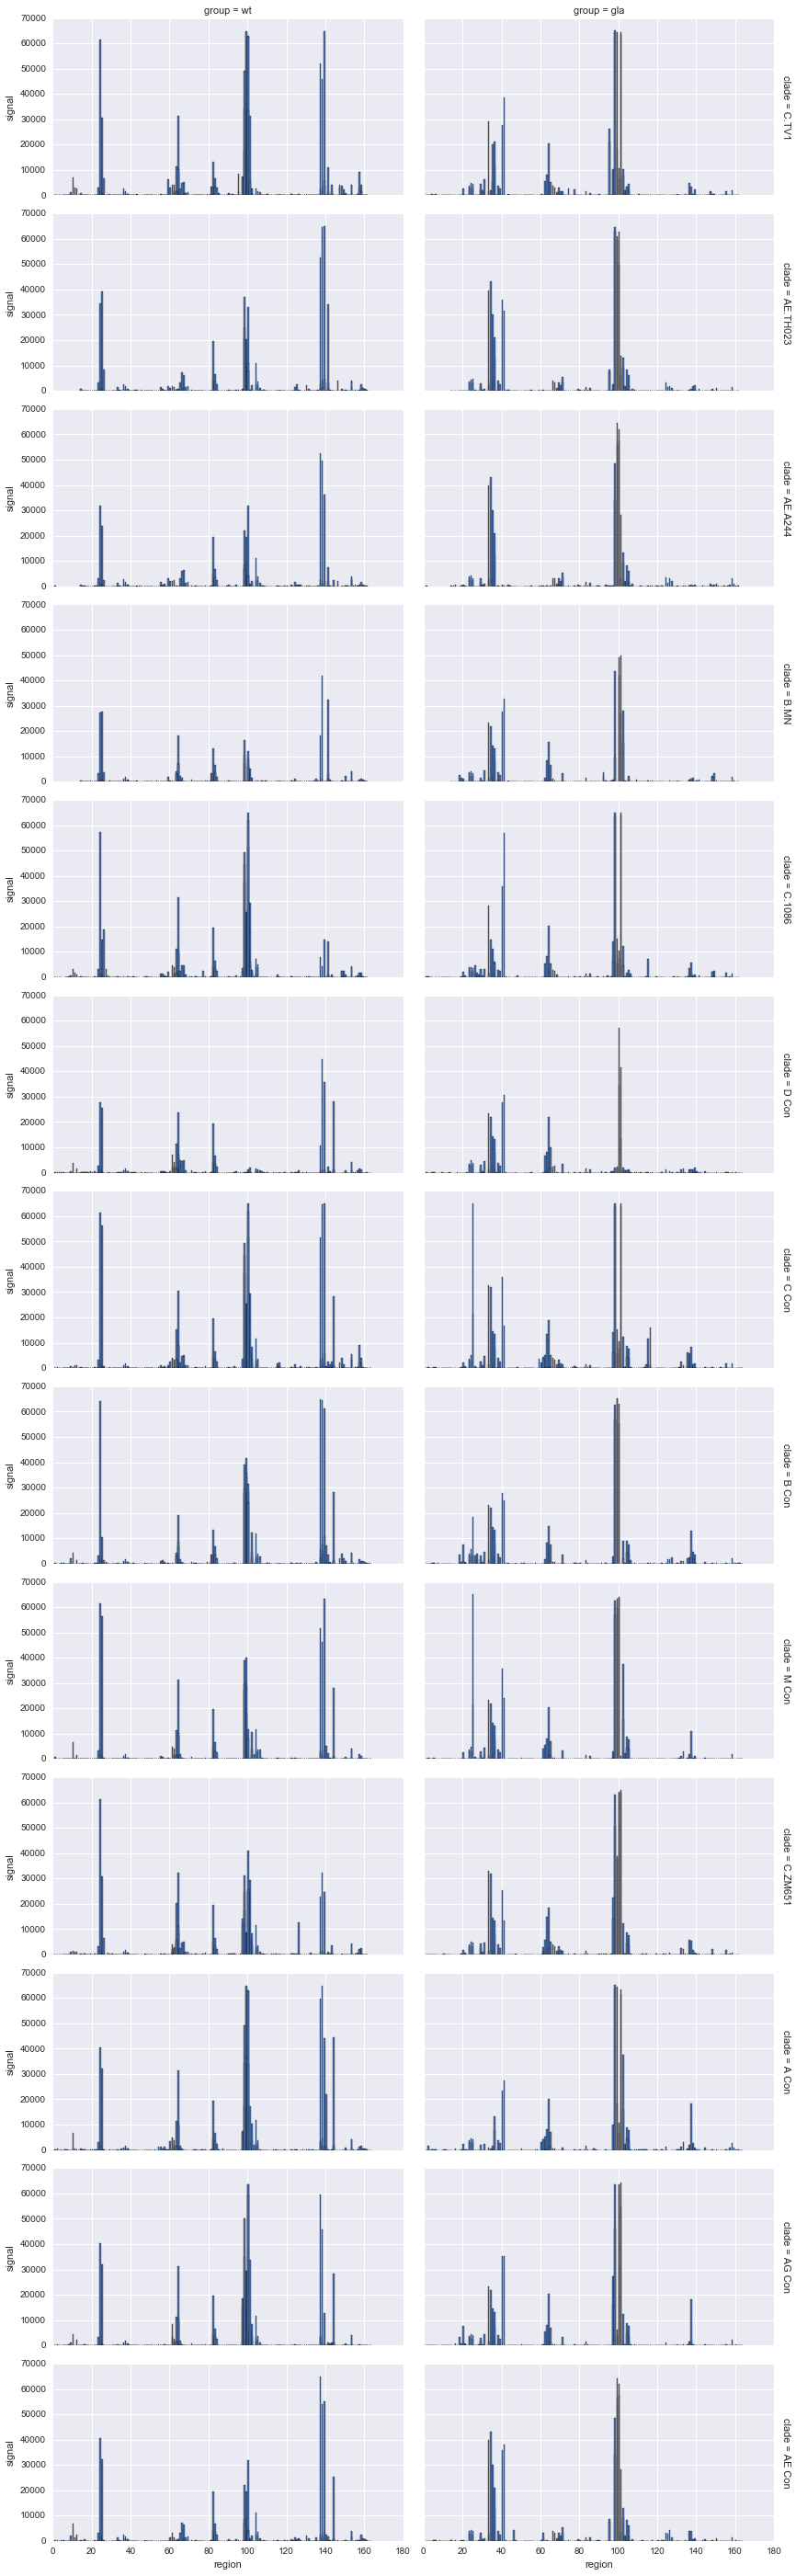

In [46]:
gp120 = data[data.protein == 'gp120']
g = sns.FacetGrid(gp120, row='clade', col='group', aspect=2, margin_titles=True)
g.map(plt.bar, 'region', 'signal')
pass

### Plotting heatmaps

In [47]:
hm = data.groupby(['region', 'subject']).agg({'signal': np.mean})
hm.head()

signal
region subject            
1.0    770        1.000000
       771      144.941271
       776       54.898099
       778       70.446511
       780        3.236776

In [48]:
hm = hm.unstack().T
hm.ix[:4, :6]

region                 1.0         2.0        3.0         4.0         5.0  \
       subject                                                              
signal 770        1.000000   65.258850   2.400000    1.000000   22.888889   
       771      144.941271   99.295281  30.186508   94.206611   43.111111   
       776       54.898099   17.535661   1.000000   33.542959   38.111111   
       778       70.446511  111.469690  37.500000  135.000000  166.111111   

region                 6.0  
       subject              
signal 770       30.400000  
       771       24.425327  
       776       48.678128  
       778      126.300000

In [49]:
hm = hm.reset_index(level=0, drop=True)
hm.ix[:4, :6]

region,1.0,2.0,3.0,4.0,5.0,6.0
subject,,,,,,
770,1.000000,65.258850,2.400000,1.000000,22.888889,30.400000
771,144.941271,99.295281,30.186508,94.206611,43.111111,24.425327
776,54.898099,17.535661,1.000000,33.542959,38.111111,48.678128
778,70.446511,111.469690,37.500000,135.000000,166.111111,126.300000


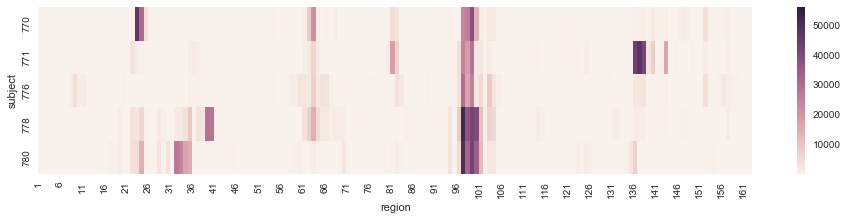

In [50]:
plt.figure(figsize=(16, 3))
sns.heatmap(hm)
xlim = [1, 163]
plt.xlim(xlim)
plt.xticks(range(xlim[0], xlim[1], 5), range(xlim[0], xlim[1], 5))
pass

### Conditioning heatmaps

Warning: This takes a while to complete.

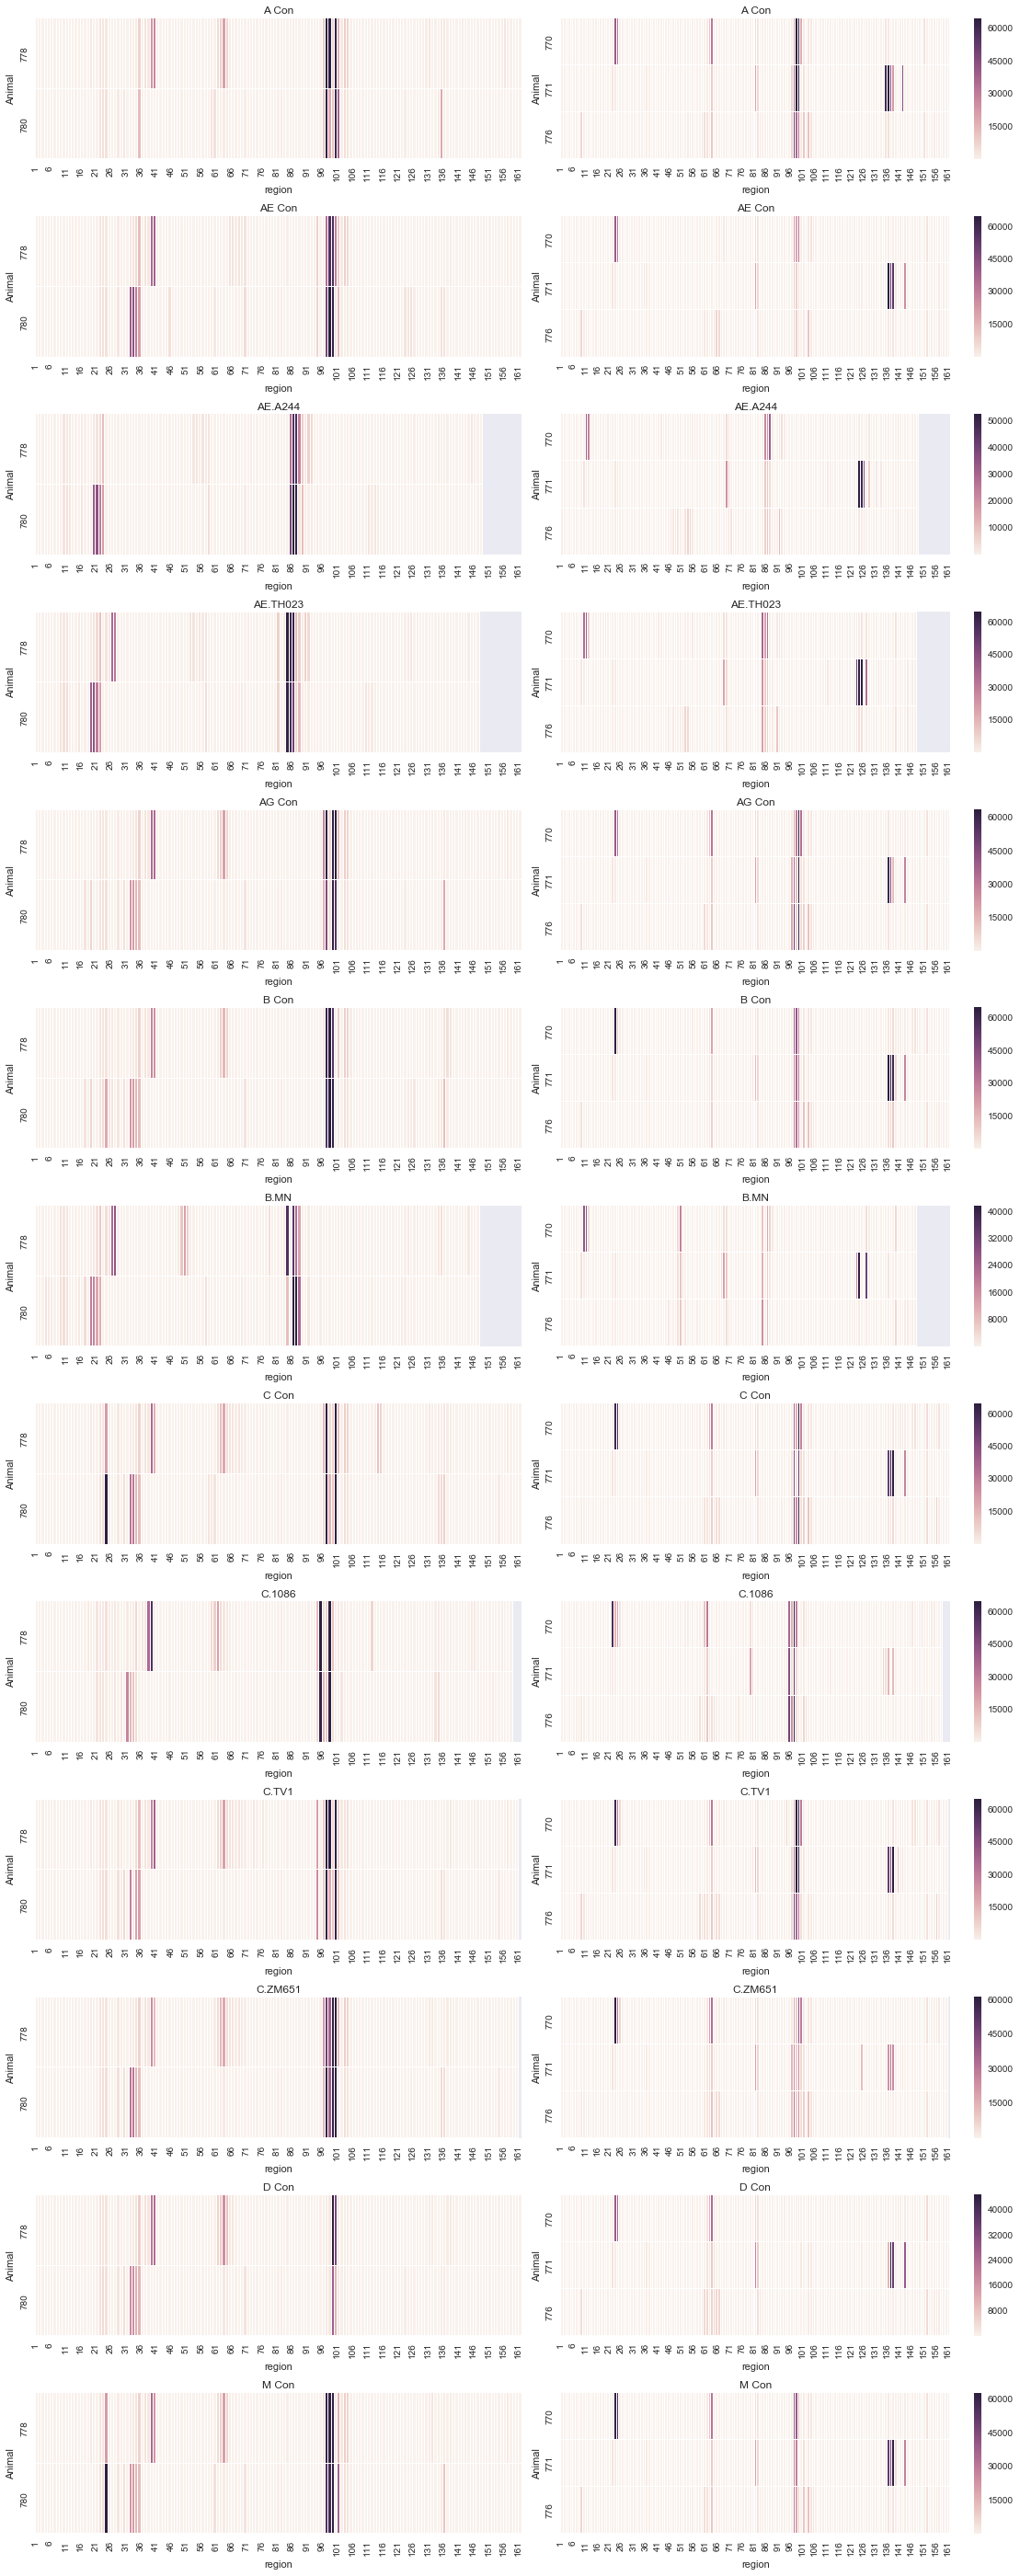

In [51]:
nrows = len(clades)
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3*nrows))

low, high, step = 1, 162, 5
for i, (clade, df_clade) in enumerate(data[data.protein == 'gp120'].groupby('clade')):
    for j, (group, df_group) in enumerate(df_clade.groupby('group')):
        ax = axes[i, j]
        hm = df_group.groupby(['region', 'subject'])[['signal']].mean()
        hm = hm.unstack().T.reset_index(level=0, drop=True)
        hm.columns = hm.columns.astype('int')
        sns.heatmap(hm, ax=ax, linewidth=0.01, cbar=j)
        ax.set_title(clade)
        ax.set_xlim(low, high)
        ax.set_xticks(range(low, high+1, step))
        ax.set_xticklabels(range(low, high+1, step))
        ax.set_ylabel('Animal')
plt.tight_layout()